In [4]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-720d6b10
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-720d6b10
  Resolved https://github.com/facebookresearch/detectron2.git to commit 3ff5dd1cff4417af07097064813c9f28d7461d3c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6120430 sha256=d5528975bc73555adca559654236

In [1]:
import cv2
import numpy as np

class GradCAM():
    """
    Class to implement the GradCam function with it's necessary Pytorch hooks.

    Attributes
    ----------
    model : detectron2 GeneralizedRCNN Model
        A model using the detectron2 API for inferencing
    layer_name : str
        name of the convolutional layer to perform GradCAM with
    """

    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.activations = None
        self.gradient = None
        self.model.eval()
        self.activations_grads = []
        self._register_hook()

    def _get_activations_hook(self, module, input, output):
        self.activations = output

    def _get_grads_hook(self, module, input_grad, output_grad):
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.model.named_modules():
            if name == self.target_layer_name:
                self.activations_grads.append(module.register_forward_hook(self._get_activations_hook))
                self.activations_grads.append(module.register_backward_hook(self._get_grads_hook))
                return True
        print(f"Layer {self.target_layer_name} not found in Model!")

    def _release_activations_grads(self):
      for handle in self.activations_grads:
            handle.remove()

    def _postprocess_cam(self, raw_cam, img_width, img_height):
        cam_orig = np.sum(raw_cam, axis=0)  # [H,W]
        cam_orig = np.maximum(cam_orig, 0)  # ReLU
        cam_orig -= np.min(cam_orig)
        cam_orig /= np.max(cam_orig)
        cam = cv2.resize(cam_orig, (img_width, img_height))
        return cam, cam_orig

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self._release_activations_grads()

    def __call__(self, inputs, target_category):
        """
        Calls the GradCAM++ instance

        Parameters
        ----------
        inputs : dict
            The input in the standard detectron2 model input format
            https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-input-format

        target_category : int, optional
            The target category index. If `None` the highest scoring class will be selected

        Returns
        -------
        cam : np.array()
          Gradient weighted class activation map
        output : list
          list of Instance objects representing the detectron2 model output
        """
        self.model.zero_grad()
        output = self.model.forward([inputs])

        if target_category == None:
          target_category =  np.argmax(output[0]['instances'].scores.cpu().data.numpy(), axis=-1)

        score = output[0]['instances'].scores[target_category]
        #box0 = output[0]['instances'].pred_boxes[0].tensor[0][target_category]
        #print(box0)
        #box0.backward()
        score.backward()

        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        activations = self.activations[0].cpu().data.numpy()  # [C,H,W]
        weight = np.mean(gradient, axis=(1, 2))  # [C]

        cam = activations * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam, cam_orig = self._postprocess_cam(cam, inputs["width"], inputs["height"])

        return cam, cam_orig, output

class GradCamPlusPlus(GradCAM):
    """
    Subclass to implement the GradCam++ function with it's necessary PyTorch hooks.
    ...

    Attributes
    ----------
    model : detectron2 GeneralizedRCNN Model
        A model using the detectron2 API for inferencing
    target_layer_name : str
        name of the convolutional layer to perform GradCAM++ with

    """
    def __init__(self, model, target_layer_name):
        super(GradCamPlusPlus, self).__init__(model, target_layer_name)

    def __call__(self, inputs, target_category):
        """
        Calls the GradCAM++ instance

        Parameters
        ----------
        inputs : dict
            The input in the standard detectron2 model input format
            https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-input-format

        target_category : int, optional
            The target category index. If `None` the highest scoring class will be selected

        Returns
        -------
        cam : np.array()
          Gradient weighted class activation map
        output : list
          list of Instance objects representing the detectron2 model output
        """
        self.model.zero_grad()
        output = self.model.forward([inputs])

        if target_category == None:
          target_category =  np.argmax(output[0]['instances'].scores.cpu().data.numpy(), axis=-1)

        score = output[0]['instances'].scores[target_category]
        score.backward()

        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        activations = self.activations[0].cpu().data.numpy()  # [C,H,W]

        #from https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/grad_cam_plusplus.py
        grads_power_2 = gradient**2
        grads_power_3 = grads_power_2 * gradient
        # Equation 19 in https://arxiv.org/abs/1710.11063
        sum_activations = np.sum(activations, axis=(1, 2))
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 +
                               sum_activations[:, None, None] * grads_power_3 + eps)
        # Now bring back the ReLU from eq.7 in the paper,
        # And zero out aijs where the activations are 0
        aij = np.where(gradient != 0, aij, 0)

        weights = np.maximum(gradient, 0) * aij
        weight = np.sum(weights, axis=(1, 2))

        cam = activations * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam, cam_orig = self._postprocess_cam(cam, inputs["width"], inputs["height"])

        return cam, cam_orig, output


In [2]:
import cv2
import detectron2.data.transforms as T
import numpy as np
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data.detection_utils import read_image
from detectron2.modeling import build_model

from torch import nn

class Detectron2GradCAM():
  """
      Attributes
    ----------
    config_file : str
        detectron2 model config file path
    model_file : str
        detectron2 model file path
    """
  def __init__(self, config_file, model_file):
      self.cfg = self._setup_cfg(config_file, model_file)

  def _setup_cfg(self, config_file, model_file):
      # load config from file, add your custom model config like RPN HEADS here
      cfg = get_cfg()
      cfg.merge_from_file(config_file)
      cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
      cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
      cfg.MODEL.WEIGHTS = model_file
      if torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cuda"
      else:
        cfg.MODEL.DEVICE = "cpu"
      cfg.freeze()
      return cfg

  def _get_input_dict(self, original_image):
      height, width = original_image.shape[:2]
      transform_gen = T.ResizeShortestEdge(
          [self.cfg.INPUT.MIN_SIZE_TEST, self.cfg.INPUT.MIN_SIZE_TEST], self.cfg.INPUT.MAX_SIZE_TEST
      )
      image = transform_gen.get_transform(original_image).apply_image(original_image)
      image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)).requires_grad_(True)
      inputs = {"image": image, "height": height, "width": width}
      return inputs

  def get_cam(self, img, target_instance, layer_name, grad_cam_type="GradCAM"):
      """
      Calls the GradCAM++ instance

      Parameters
      ----------
      img : str
          Path to inference image
      target_instance : int
          The target instance index
      layer_name : str
          Convolutional layer to perform GradCAM on
      grad_cam_type : str
          GradCAM or GradCAM++ (for multiple instances of the same object, GradCAM++ can be favorable)

      Returns
      -------
      image_dict : dict
        {"image" : <image>, "cam" : <cam>, "output" : <output>, "label" : <label>}
        <image> original input image
        <cam> class activation map resized to original image shape
        <output> instances object generated by the model
        <label> label of the
      cam_orig : numpy.ndarray
        unprocessed raw cam
      """
      model = build_model(self.cfg)
      checkpointer = DetectionCheckpointer(model)
      checkpointer.load(self.cfg.MODEL.WEIGHTS)

      image = read_image(img, format="BGR")
      input_image_dict = self._get_input_dict(image)

      if grad_cam_type == "GradCAM":
        grad_cam = GradCAM(model, layer_name)

      elif grad_cam_type == "GradCAM++":
        grad_cam = GradCamPlusPlus(model, layer_name)

      else:
        raise ValueError('Grad CAM type not specified')

      with grad_cam as cam:
        cam, cam_orig, output = cam(input_image_dict, target_category=target_instance)

      image_dict = {}
      image_dict["image"] = image
      image_dict["cam"] = cam
      image_dict["output"] = output
      image_dict["label"] = MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]).thing_classes[output[0]["instances"].pred_classes[target_instance]]

      return image_dict, cam_orig

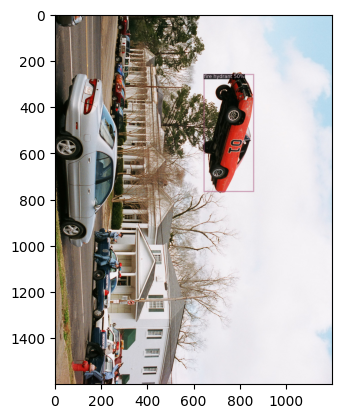

In [27]:
from google.colab.patches import cv2_imshow

!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("/fire_hydatant.png")
cv2_imshow(im)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


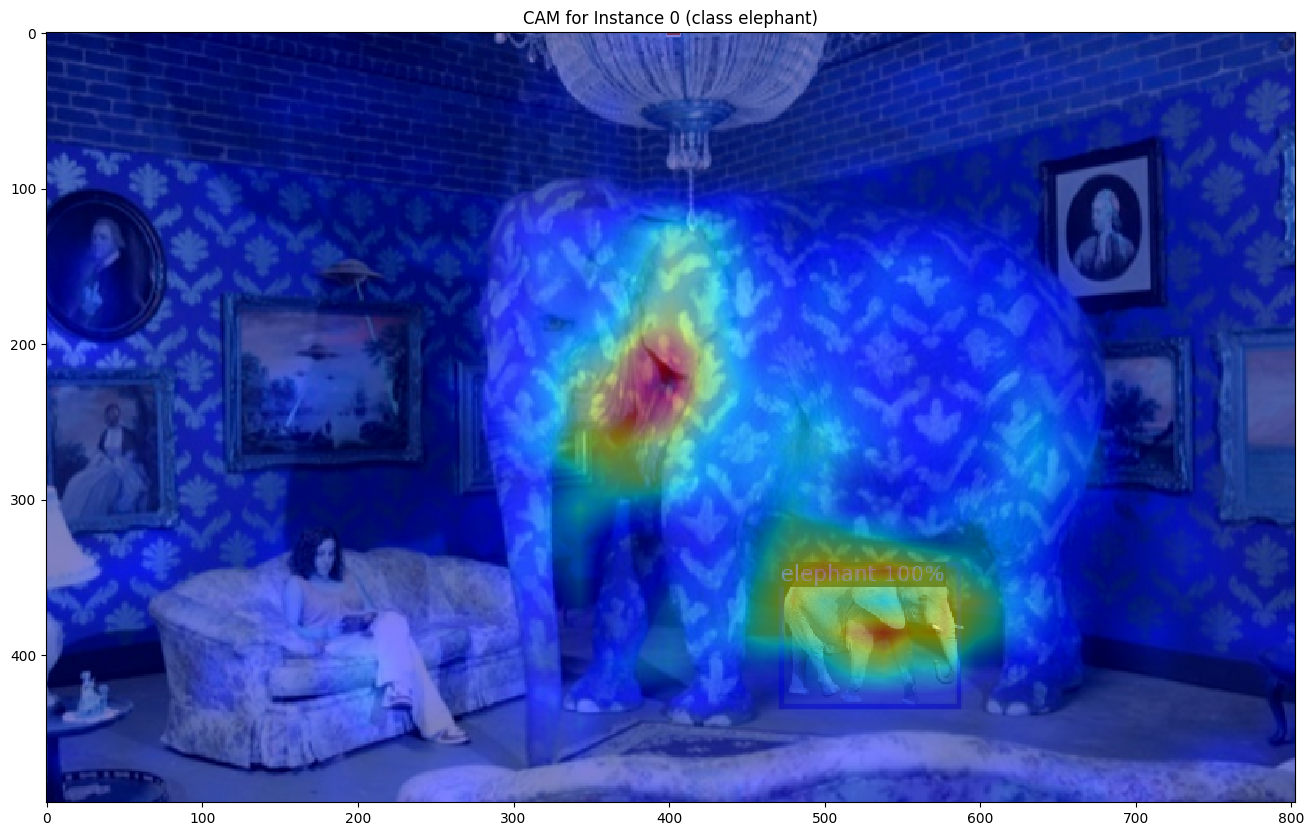

In [15]:
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo

"""
choose the object instance you want to perfrom GradCAM on. It's defined by `instance = 0`
"""

plt.rcParams["figure.figsize"] = (30,10)

img = "/new8.jpg"
config_file = model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
model_file = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

layer_name = "backbone.bottom_up.res5.2.conv3"
instance = 0 #CAM is generated per object instance, not per class!
cam_extractor = Detectron2GradCAM(config_file=config_file, model_file=model_file)

image_dict, cam_orig = cam_extractor.get_cam(img=img, target_instance=instance, layer_name=layer_name, grad_cam_type="GradCAM")
v = Visualizer(image_dict["image"], MetadataCatalog.get(cam_extractor.cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(image_dict["output"][0]["instances"][instance].to("cpu"))

plt.imshow(out.get_image(), interpolation='none')
plt.imshow(image_dict["cam"], cmap='jet', alpha=0.5)

plt.title(f"CAM for Instance {instance} (class {image_dict['label']})")
plt.show()